In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from scipy.signal import lfilter

In [2]:
def remove_noise(frame, first_par, second_par):
    w_out_noise = savgol_filter(frame["StockValue"], first_par, second_par
                                ,mode='interp' #interp
                               )
    frame["StockValue"] = w_out_noise
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [3]:
def remove_noise_lFilter(frame, b, a):
    w_out_noise_lFilter = lfilter(b, a, frame["StockValue"])
    frame["StockValue"] = w_out_noise_lFilter
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [4]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [5]:
def buy_sell_recommendations(new_frame):
    ### ma_50_200 farkı sıfırdan büyük veya 5 günlük trajectory değeri sıfırdan büyükse;
    new_frame['rec_1'] = np.where(((new_frame["MA_50_200"]>0) | (new_frame["MA_50_200_CH"]>0)) & ((new_frame["MA_14_100"] > 0.5) & (new_frame["MA_7_50"] > 0.5))
                                  & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*0.8)
                                         ,"BUY", "SELL")
    
    new_frame['rec_2'] = np.where(((new_frame["MA_50_200"]>0) | (new_frame["MA_50_200_CH"]>0)) & ((new_frame["MA_14_100"] > 0.5) & (new_frame["MA_7_50"] > 0.5))
                                  & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*0.8)
                                     ,"BUY", "SELL")
    
    return new_frame

In [6]:
def get_locations(new_frame):
    loc_first=[]
    for row in range(new_frame.shape[0]-1):

            if new_frame.iloc[row,:].rec_1 == "SELL":
                if new_frame.iloc[row+1,:].rec_1 == "BUY":
                    start = row+1
                    loc_first.append(start)

            if new_frame.iloc[row,:].rec_1 == "BUY":
                if new_frame.iloc[row+1,:].rec_1 == "SELL":
                    end = row+2
                    loc_first.append(end)
                    
    loc_second=[]
    for row in range(new_frame.shape[0]-1):

        if new_frame.iloc[row,:].rec_2 == "SELL":
            if new_frame.iloc[row+1,:].rec_2 == "BUY":
                start = row+1
                loc_second.append(start)

        if new_frame.iloc[row,:].rec_2 == "BUY":
            if new_frame.iloc[row+1,:].rec_2 == "SELL":
                end = row+2
                loc_second.append(end)
                
    return [loc_first, loc_second]

In [7]:
def get_transactions(new_frame, column, locations):
    if new_frame.iloc[0,:][str(column)] == "SELL":
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(0,len(locations),2), range(1,len(locations),2))]
    else:
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(1,len(locations),2), range(2,len(locations),2))]
        transactions.insert(0, [0, locations[0]])

    return transactions

In [8]:
def returns(new_frame, list_of_transactions):
    returns = []
    for transactions in list_of_transactions:
        buy = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[0]
        sell = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[-1]
        ret = (sell-buy)/buy
        returns.append(ret)
    
    return returns

In [9]:
def prod(list_of_all_returns):
    return np.prod([ret+1 for ret in list_of_all_returns]) 

In [10]:
def get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [11]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%d-%m-%Y")

In [12]:
def convert_str_from_date(date: str):
    return datetime.datetime.strftime(date, "%d-%m-%Y")

In [13]:
def increment_date(date:str, increment_day:int):
    date = convert_date(date)
    date = date + datetime.timedelta(days=increment_day)
    date = convert_str_from_date(date)
    
    return date

In [14]:
increment_date("01-01-2015", 2)

'03-01-2015'

In [15]:
def simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    loc_first = get_locations(new_frame)[0]
    loc_second = get_locations(new_frame)[1]
    
    first_transactions = get_transactions(new_frame, "rec_1", loc_first)
    second_transactions = get_transactions(new_frame, "rec_2", loc_second)

    first_returns = returns(new_frame, first_transactions)
    second_returns = returns(new_frame, second_transactions)
    
    first_cum_return = prod(first_returns)
    print(f"Final position of first transactions : {first_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in first_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of first transactions        : {[round(first,3) for first in first_returns]}")
    print(f"Locations of first transactions      : {first_transactions}")
    print("-"*85)
    
    second_cum_return  = prod(second_returns)
    print(f"Final position of second transactions: {second_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in second_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of second transactions       : {[round(second,3) for second in second_returns]}")
    print(f"Locations of second transactions     : {second_transactions}")
    print("-"*85)

    totalReturn = (first_cum_return + second_cum_return) / 2
    print(f"Ultimate position : {totalReturn}")
    
    return totalReturn

In [16]:
def stop_loss_scan(new_frame, transactionSet:list, threshold:float):
    part_frame = new_frame.iloc[transactionSet[0]:transactionSet[1],:]
    values = part_frame["StockValue"]
    start = list(values)[0]
    counter = 1
    mode = "non_changed"
    for value in list(values[1:]):
        if (value / start) > (1-threshold):
            counter += 1
        else:
            mode = "changed"
            counter+=1
            break
    return counter

In [17]:
def update_transaction_list_thresholdBased(new_frame, transactions, threshold):
    for transactionSet in transactions:
        new_end_loc = stop_loss_scan(new_frame, transactionSet, threshold)
        transactionSet[1] = transactionSet[0] + new_end_loc
    return transactions

---

---

In [18]:
def get_only_frame_simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = pd.read_pickle(stock_name)
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    frame = frame[(frame.HGDG_TARIH < end_date) & (frame.HGDG_TARIH > start_date)]
    date = frame[["HGDG_TARIH"]]
    
    # frame = frame.iloc[-100:,:]
    new_frame = remove_noise(frame, noise_first_par, noise_second_par)           # SAVGOL FILTER
    # new_frame = remove_noise_lFilter(frame, noise_first_par, noise_second_par)     # LFILTER
    
    #scaling
    ## scaling
    # new_frame["StockValue"] = scale(new_frame["StockValue"])
    ## min_max scaling
    # new_frame = new_frame.iloc[-50:,:]
    # scaler = MinMaxScaler()
    # new_frame[["StockValue"]] = scaler.fit_transform(new_frame[["StockValue"]])
    
    # new_frame = ma_columns(frame_f, ma_list)
    
    # new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    # new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    # new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    # frame = pd.read_pickle(stock_name)
    # new_frame = new_frame[["HGDG_TARIH", "StockValue"]]
    # new_frame = new_frame.join(frame)
    
    # new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.join(date)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [19]:
def extract_and_store(stock_name, start_date, end_date):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)

In [41]:
stock_name = "TKFEN"
ma_list=[7,14,50,100,200]
noise_first_par = 51
noise_second_par = 2

# n = 15  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# noise_first_par = b
# noise_second_par = a

general_startDate = "31-01-2000"
general_endDate = "31-12-2020"

start_date = "01-01-2011"
first_end_date = "01-02-2014"
final_last_date = "01-07-2020"
end_date = "01-07-2020"

In [21]:
# extract stock values and store
extract_and_store(stock_name, general_startDate, general_endDate)

In [22]:
observations = []
for i in range(2400):
    frame = pd.read_pickle(stock_name)
    print(first_end_date)
    if frame[frame["HGDG_TARIH"] == first_end_date].shape[0] == 1:
        frame = get_only_frame_simulation(stock_name, start_date, first_end_date, ma_list, noise_first_par, noise_second_par)
        observations.append(frame.iloc[-1,:])
    else:
        observations = observations
    first_end_date = increment_date(first_end_date, 1)

final_frame = pd.concat(observations, axis=1)
final_frame = final_frame.T
final_frame = final_frame.drop_duplicates(subset=["Date"])

new_frame = ma_columns(final_frame, ma_list)
final_frame = final_frame.join(new_frame)
final_frame = final_frame.dropna()

final_frame["MA_7_50"] = final_frame["MA_7"] - final_frame["MA_50"]
final_frame["MA_14_100"] = final_frame["MA_14"] - final_frame["MA_100"]
final_frame["MA_50_200"] = final_frame["MA_50"] - final_frame["MA_200"]

trajectory1 = sm.trajectory(final_frame[["MA_50_200"]], 20)[["MA_50_200_CH"]]
#trajectory2 = sm.trajectory(final_frame[["MA_14_100"]], 10)[["MA_14_100_CH"]]
#trajectory3 = sm.trajectory(final_frame[["MA_7_50"]], 5)[["MA_7_50_CH"]]
final_frame = final_frame.join(trajectory1)
#final_frame = final_frame.join(trajectory2)
#final_frame = final_frame.join(trajectory3)

# final_frame["MA_50_200"] = scale(final_frame["MA_50_200"]) # SCALING ZAMANA GÖRE YAP
# final_frame["MA_14_100"] = scale(final_frame["MA_14_100"])
# final_frame["MA_7_50"] = scale(final_frame["MA_7_50"])

# final_frame = buy_sell_recommendations(final_frame)
final_frame = final_frame.rename(columns={"StockValue": "StockValue_WoN"})

frame = pd.read_pickle(stock_name)
frame = frame[["StockValue"]]
final_frame = final_frame.join(frame)

final_frame = final_frame.dropna()
final_frame = buy_sell_recommendations(final_frame)

01-02-2014
02-02-2014
03-02-2014
04-02-2014
05-02-2014
06-02-2014
07-02-2014
08-02-2014
09-02-2014
10-02-2014
11-02-2014
12-02-2014
13-02-2014
14-02-2014
15-02-2014
16-02-2014
17-02-2014
18-02-2014
19-02-2014
20-02-2014
21-02-2014
22-02-2014
23-02-2014
24-02-2014
25-02-2014
26-02-2014
27-02-2014
28-02-2014
01-03-2014
02-03-2014
03-03-2014
04-03-2014
05-03-2014
06-03-2014
07-03-2014
08-03-2014
09-03-2014
10-03-2014
11-03-2014
12-03-2014
13-03-2014
14-03-2014
15-03-2014
16-03-2014
17-03-2014
18-03-2014
19-03-2014
20-03-2014
21-03-2014
22-03-2014
23-03-2014
24-03-2014
25-03-2014
26-03-2014
27-03-2014
28-03-2014
29-03-2014
30-03-2014
31-03-2014
01-04-2014
02-04-2014
03-04-2014
04-04-2014
05-04-2014
06-04-2014
07-04-2014
08-04-2014
09-04-2014
10-04-2014
11-04-2014
12-04-2014
13-04-2014
14-04-2014
15-04-2014
16-04-2014
17-04-2014
18-04-2014
19-04-2014
20-04-2014
21-04-2014
22-04-2014
23-04-2014
24-04-2014
25-04-2014
26-04-2014
27-04-2014
28-04-2014
29-04-2014
30-04-2014
01-05-2014
02-05-2014

01-03-2016
02-03-2016
03-03-2016
04-03-2016
05-03-2016
06-03-2016
07-03-2016
08-03-2016
09-03-2016
10-03-2016
11-03-2016
12-03-2016
13-03-2016
14-03-2016
15-03-2016
16-03-2016
17-03-2016
18-03-2016
19-03-2016
20-03-2016
21-03-2016
22-03-2016
23-03-2016
24-03-2016
25-03-2016
26-03-2016
27-03-2016
28-03-2016
29-03-2016
30-03-2016
31-03-2016
01-04-2016
02-04-2016
03-04-2016
04-04-2016
05-04-2016
06-04-2016
07-04-2016
08-04-2016
09-04-2016
10-04-2016
11-04-2016
12-04-2016
13-04-2016
14-04-2016
15-04-2016
16-04-2016
17-04-2016
18-04-2016
19-04-2016
20-04-2016
21-04-2016
22-04-2016
23-04-2016
24-04-2016
25-04-2016
26-04-2016
27-04-2016
28-04-2016
29-04-2016
30-04-2016
01-05-2016
02-05-2016
03-05-2016
04-05-2016
05-05-2016
06-05-2016
07-05-2016
08-05-2016
09-05-2016
10-05-2016
11-05-2016
12-05-2016
13-05-2016
14-05-2016
15-05-2016
16-05-2016
17-05-2016
18-05-2016
19-05-2016
20-05-2016
21-05-2016
22-05-2016
23-05-2016
24-05-2016
25-05-2016
26-05-2016
27-05-2016
28-05-2016
29-05-2016
30-05-2016

27-03-2018
28-03-2018
29-03-2018
30-03-2018
31-03-2018
01-04-2018
02-04-2018
03-04-2018
04-04-2018
05-04-2018
06-04-2018
07-04-2018
08-04-2018
09-04-2018
10-04-2018
11-04-2018
12-04-2018
13-04-2018
14-04-2018
15-04-2018
16-04-2018
17-04-2018
18-04-2018
19-04-2018
20-04-2018
21-04-2018
22-04-2018
23-04-2018
24-04-2018
25-04-2018
26-04-2018
27-04-2018
28-04-2018
29-04-2018
30-04-2018
01-05-2018
02-05-2018
03-05-2018
04-05-2018
05-05-2018
06-05-2018
07-05-2018
08-05-2018
09-05-2018
10-05-2018
11-05-2018
12-05-2018
13-05-2018
14-05-2018
15-05-2018
16-05-2018
17-05-2018
18-05-2018
19-05-2018
20-05-2018
21-05-2018
22-05-2018
23-05-2018
24-05-2018
25-05-2018
26-05-2018
27-05-2018
28-05-2018
29-05-2018
30-05-2018
31-05-2018
01-06-2018
02-06-2018
03-06-2018
04-06-2018
05-06-2018
06-06-2018
07-06-2018
08-06-2018
09-06-2018
10-06-2018
11-06-2018
12-06-2018
13-06-2018
14-06-2018
15-06-2018
16-06-2018
17-06-2018
18-06-2018
19-06-2018
20-06-2018
21-06-2018
22-06-2018
23-06-2018
24-06-2018
25-06-2018

18-04-2020
19-04-2020
20-04-2020
21-04-2020
22-04-2020
23-04-2020
24-04-2020
25-04-2020
26-04-2020
27-04-2020
28-04-2020
29-04-2020
30-04-2020
01-05-2020
02-05-2020
03-05-2020
04-05-2020
05-05-2020
06-05-2020
07-05-2020
08-05-2020
09-05-2020
10-05-2020
11-05-2020
12-05-2020
13-05-2020
14-05-2020
15-05-2020
16-05-2020
17-05-2020
18-05-2020
19-05-2020
20-05-2020
21-05-2020
22-05-2020
23-05-2020
24-05-2020
25-05-2020
26-05-2020
27-05-2020
28-05-2020
29-05-2020
30-05-2020
31-05-2020
01-06-2020
02-06-2020
03-06-2020
04-06-2020
05-06-2020
06-06-2020
07-06-2020
08-06-2020
09-06-2020
10-06-2020
11-06-2020
12-06-2020
13-06-2020
14-06-2020
15-06-2020
16-06-2020
17-06-2020
18-06-2020
19-06-2020
20-06-2020
21-06-2020
22-06-2020
23-06-2020
24-06-2020
25-06-2020
26-06-2020
27-06-2020
28-06-2020
29-06-2020
30-06-2020
01-07-2020
02-07-2020
03-07-2020
04-07-2020
05-07-2020
06-07-2020
07-07-2020
08-07-2020
09-07-2020
10-07-2020
11-07-2020
12-07-2020
13-07-2020
14-07-2020
15-07-2020
16-07-2020
17-07-2020

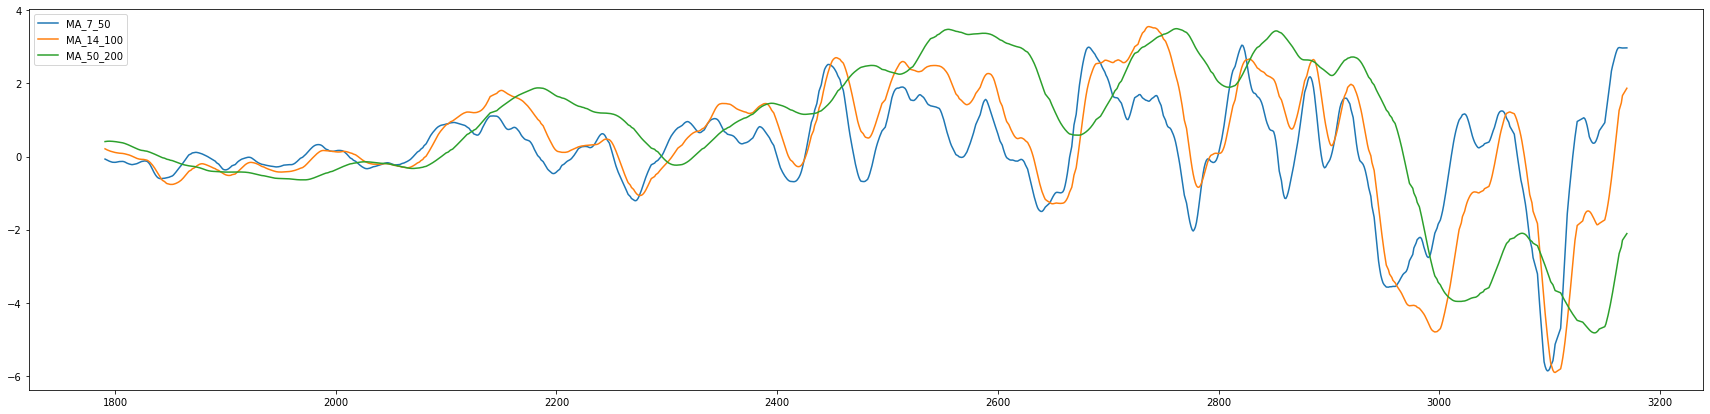

In [23]:
final_frame.iloc[:,:][["MA_7_50","MA_14_100","MA_50_200"]].plot(figsize=(30,7))

In [24]:
final_frame.iloc[:,:]

,StockValue_WoN,Date,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,MA_50_200_CH,StockValue,rec_1,rec_2
1791,4.61359,2015-01-15,4.636800,4.659150,4.705009,4.446380,4.294408,-0.068209,0.212771,0.410601,0.028821,4.6737,SELL,SELL
1792,4.59962,2015-01-16,4.630825,4.648856,4.714459,4.452470,4.299256,-0.083634,0.196385,0.415203,0.027613,4.6012,SELL,SELL
1793,4.60478,2015-01-19,4.623020,4.640186,4.722996,4.458583,4.304262,-0.099976,0.181604,0.418734,0.026383,4.7140,SELL,SELL
1794,4.59894,2015-01-20,4.615363,4.632963,4.730095,4.464395,4.309332,-0.114732,0.168568,0.420763,0.024951,4.6254,SELL,SELL
1795,4.58568,2015-01-21,4.607960,4.626251,4.735915,4.469937,4.314474,-0.127955,0.156313,0.421441,0.023390,4.5448,SELL,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3162,17.7966,2020-06-30,17.294688,16.386937,14.326681,15.383749,17.163090,2.968006,1.003188,-2.836409,-0.025686,17.0200,SELL,SELL
3163,17.8432,2020-07-01,17.460727,16.649618,14.476969,15.382410,17.130816,2.983758,1.267207,-2.653847,-0.029084,16.8600,SELL,SELL
3165,17.9361,2020-07-03,17.605990,16.851613,14.628887,15.379719,17.098655,2.977103,1.471894,-2.469769,-0.032656,16.8200,SELL,SELL
3166,18.0905,2020-07-06,17.749568,17.048974,14.778262,15.379759,17.067074,2.971306,1.669215,-2.288812,-0.036348,17.8100,SELL,SELL


In [25]:
all_locations = get_locations(final_frame)

In [26]:
first_transactions = get_transactions(final_frame, "rec_1", get_locations(final_frame)[0])

In [27]:
first_transactions = update_transaction_list_thresholdBased(final_frame, first_transactions, 0.03)

In [28]:
second_transactions = get_transactions(final_frame, "rec_2", get_locations(final_frame)[1])

In [29]:
second_transactions = update_transaction_list_thresholdBased(final_frame, second_transactions, 0.03)

In [30]:
first_transactions

[[279, 306],
 [311, 315],
 [478, 481],
 [484, 513],
 [583, 610],
 [650, 661],
 [802, 805],
 [925, 930],
 [994, 998]]

In [31]:
first_returns = returns(final_frame, first_transactions)
first_returns

[0.31617969742464486,
 -0.06199052435114143,
 0.007813944886258549,
 0.17108951313143622,
 0.07294695150212792,
 0.03433304722460653,
 -0.03666724247135377,
 -0.03130121420099047,
 -0.029364546790455952]

In [32]:
second_returns = returns(final_frame, second_transactions)
second_returns

[0.4849751703429956,
 0.007813944886258549,
 0.16307659496679056,
 -0.040606432633395494,
 -0.030078627591136515,
 -0.03757482415331608,
 -0.03666724247135377,
 -0.05490010129965292,
 -0.03083015015806107]

In [33]:
first_cum_return = prod(first_returns)
second_cum_return  = prod(second_returns)

In [34]:
first_cum_return

1.4647137318993229

In [35]:
second_cum_return

1.3755048257257134

In [36]:
duration_1 = sum([t[1]-t[0] for t in first_transactions])
duration_1

113

In [37]:
duration_2 = sum([t[1]-t[0] for t in second_transactions])
duration_2

152

In [38]:
total_duration = final_frame.shape[0]
total_duration

1237

In [39]:
pow(((first_cum_return + second_cum_return) / 2), (total_duration / ((duration_1 + duration_2) / 2)))

26.427312889594738

In [40]:
def frame(stock_name, ma_list, start_date, end_date):
    frame = pd.read_pickle(stock_name)
    
    frame = frame[(frame.HGDG_TARIH < end_date) & (frame.HGDG_TARIH > start_date)]
    date = frame[["HGDG_TARIH"]]
    
    movingAverages = ma_columns(frame[["StockValue"]], ma_list)
    
    frame = frame.join(movingAverages)
    
    frame["StockValue_30_lag"] = frame["StockValue"].pct_change(30)
    
    frame = frame.dropna()
    
    return frame

In [42]:
frame = frame(stock_name, ma_list, start_date, end_date)

In [43]:
frame

,HGDG_HS_KODU,HGDG_TARIH,StockValue,HGDG_AOF,HGDG_MIN,HGDG_MAX,HGDG_HACIM,END_ENDEKS_KODU,END_TARIH,END_SEANS,...,HG_HACIM,DOLAR_BAZLI_MIN,DOLAR_BAZLI_MAX,DOLAR_BAZLI_AOF,MA_7,MA_14,MA_50,MA_100,MA_200,StockValue_30_lag
974,TKFEN,2011-10-13,4.2918,4.308356,4.247406,4.365799,4511493.0,01,1318453200000,2,...,2818641.0,2.3188,2.3835,2.3521,4.272771,4.204057,3.866744,4.058785,4.320085,0.106876
975,TKFEN,2011-10-14,4.3658,4.340072,4.277004,4.380599,10109477.0,01,1318539600000,2,...,8911547.0,2.3280,2.3844,2.3623,4.306600,4.238943,3.869704,4.059244,4.317858,0.121679
976,TKFEN,2011-10-17,4.3806,4.414365,4.365799,4.469395,6821148.0,01,1318798800000,2,...,3258470.0,2.3674,2.4236,2.3938,4.331971,4.262200,3.873256,4.059418,4.314983,0.174613
977,TKFEN,2011-10-18,4.3510,4.387999,4.321402,4.454596,9469873.0,01,1318885200000,2,...,2293452.0,2.3149,2.3862,2.3505,4.342543,4.271714,3.878584,4.059440,4.311021,0.157489
978,TKFEN,2011-10-19,4.2622,4.321977,4.247406,4.410198,2676088.0,01,1318971600000,2,...,2031779.0,2.2949,2.3829,2.3352,4.329857,4.269600,3.889240,4.059144,4.306254,0.129419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,TKFEN,2019-12-30,18.8690,18.785418,18.523270,18.984190,254936284.0,01,1577653200000,2,...,254936284.0,3.1127,3.1901,3.1567,18.236557,17.891557,17.581450,18.313258,20.992829,0.060443
3038,TKFEN,2019-12-31,18.5521,18.742207,18.552076,19.012997,140888186.0,01,1577739600000,2,...,140888186.0,3.1176,3.1951,3.1496,18.383343,17.987586,17.627926,18.284643,20.968051,0.013643
3039,TKFEN,2020-01-02,18.8402,18.833431,18.648102,18.897768,185253074.0,01,1577912400000,2,...,185253074.0,3.1297,3.1716,3.1608,18.517786,18.078129,17.671138,18.268127,20.945531,0.028844
3040,TKFEN,2020-01-03,18.0719,18.257280,17.889502,18.724922,238182243.0,01,1577998800000,2,...,238182243.0,2.9949,3.1347,3.0564,18.490343,18.127507,17.694568,18.242200,20.923901,-0.004237
